Classification Model to Predict Program Performance Score

In [1]:
import sys
import os
import warnings
from statistics import fmean, stdev

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

In [2]:
x_data = pd.read_csv('x_all.csv')
x = x_data.to_numpy()
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
    

In [3]:
def find_x_scaled_sample(sample: list):
    """
    Return index of sample from x_all data
    """
    for i in range(len(x_scaled)):
        found = True
        for j in range(len(sample)):
            if sample[j] != x_scaled[i][j]:
                found = False
        if found:
            return i - 2

In [4]:
y_data = pd.read_csv('y_all.csv')
y = y_data.to_numpy().ravel()

In [5]:
def get_best_model_parameters(model, x, y, cv, parameters):
    """
    """
    grid_search = GridSearchCV(model(), parameters, n_jobs=-1)
    grid_search.fit(x, y)
    print("Best parameters combination found:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print(f"{param_name}: {best_parameters[param_name]}")

    return best_parameters

def train_and_evaluate_model(model, x, y, test_size, random_state):
    """
    """
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
    model.fit(x_train, y_train)
    scores = cross_val_score(model, x_train, y_train)
    return model.score(x_train, y_train), scores.mean(), scores.std(), model.score(x_test, y_test)

In [6]:
def plot_random_seed_runs(model, runs):
    """
    """
    training_scores = []
    cross_val_means = []
    cross_val_standard_deviations = []
    test_scores = []
    for i in range(runs):
        training, mean, sd, test = train_and_evaluate_model(model, x_scaled, y, 0.2, i)
        training_scores.append(training)
        cross_val_means.append(mean)
        cross_val_standard_deviations.append(sd)
        test_scores.append(test)
    return training_scores, cross_val_means, cross_val_standard_deviations, test_scores

In [7]:
NN_parameters = {
    'hidden_layer_sizes': [(10, 10), (15,), (16,), (17,), (18,), (20,), (20, 20)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.00001, 0.0001, 0.001, 0.01],
    'max_iter': [200, 300, 400, 500],
    'tol': [0.00001, 0.0001, 0.001, 0.01],
    'random_state': [1],
}
NN_best_parameters = get_best_model_parameters(MLPClassifier, x_scaled, y, 5, NN_parameters)

Best parameters combination found:
activation: relu
alpha: 0.01
hidden_layer_sizes: (18,)
max_iter: 200
random_state: 1
solver: lbfgs
tol: 1e-05


0.9951086956521739
0.7704093567251462
0.07815629678149465
0.7717391304347826
0.09343700861887551


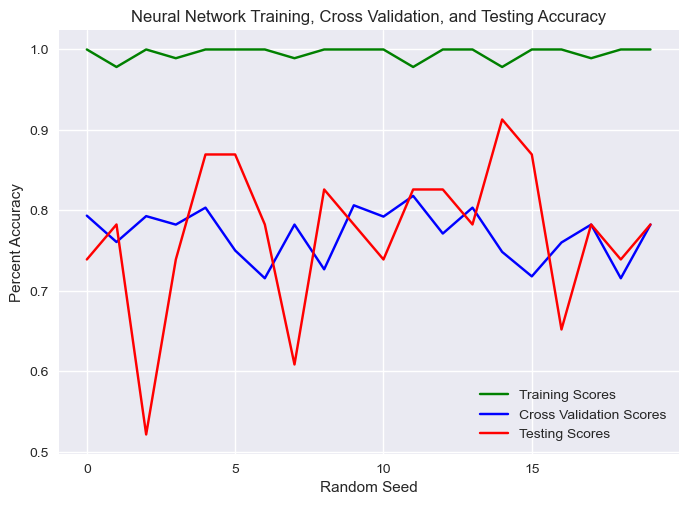

In [8]:
NN_best = MLPClassifier(
    activation=NN_best_parameters['activation'],
    alpha=NN_best_parameters['alpha'],
    hidden_layer_sizes=NN_best_parameters['hidden_layer_sizes'],
    solver=NN_best_parameters['solver'],
    max_iter=NN_best_parameters['max_iter'],
    tol=NN_best_parameters['tol'],
    random_state=NN_best_parameters['random_state'],
)

NN_training_scores, NN_cross_val_means, NN_cross_val_standard_deviations, NN_test_scores = plot_random_seed_runs(NN_best, 20)

print(fmean(NN_training_scores))
print(fmean(NN_cross_val_means))
print(fmean(NN_cross_val_standard_deviations))
print(fmean(NN_test_scores))
print(stdev(NN_test_scores))

random_seeds = [x for x in range(20)]

plt.title('Neural Network Training, Cross Validation, and Testing Accuracy')
plt.xlabel('Random Seed')
plt.xticks(np.linspace(0, 20, 5))
plt.ylabel('Percent Accuracy')
plt.plot(random_seeds, NN_training_scores, color='green', label='Training Scores')
plt.plot(random_seeds, NN_cross_val_means, color='blue', label='Cross Validation Scores')
plt.plot(random_seeds, NN_test_scores, color='red', label='Testing Scores')
plt.legend()
plt.show()

In [9]:
LR_parameters = {
    'C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0],
    'penalty': [None, 'l1', 'l2', 'elasticnet'],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'],
    'max_iter': [100, 200, 300, 400, 500],
    'class_weight': [None, 'balanced'],
    'warm_start': [False, True],
    'tol': [0.00001, 0.0001],
    'random_state': [1],
}
LR_best_paramters = get_best_model_parameters(LogisticRegression, x_scaled, y, 5, LR_parameters)

Best parameters combination found:
C: 1e-06
class_weight: None
max_iter: 200
penalty: None
random_state: 1
solver: sag
tol: 1e-05
warm_start: False


0.8668478260869564
0.766842105263158
0.07953345094463643
0.7695652173913043
0.0692498572710909


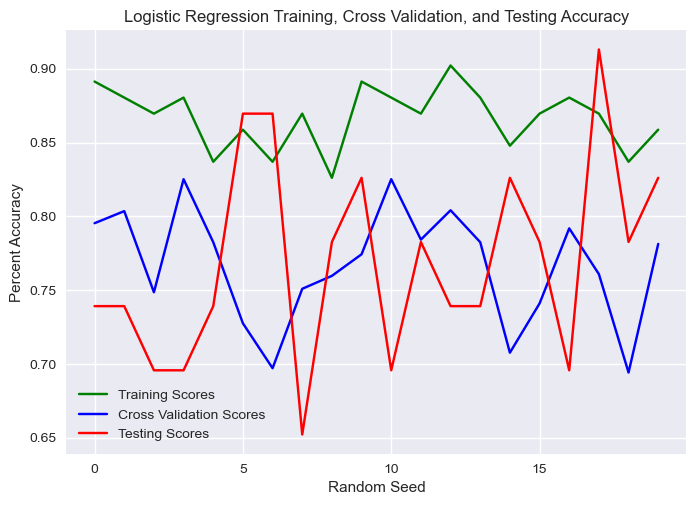

In [10]:
LR_best = LogisticRegression(
    C=LR_best_paramters['C'],
    class_weight=LR_best_paramters['class_weight'],
    max_iter=LR_best_paramters['max_iter'],
    penalty=LR_best_paramters['penalty'],
    solver=LR_best_paramters['solver'],
    tol=LR_best_paramters['tol'],
    warm_start=LR_best_paramters['warm_start'],
    random_state=LR_best_paramters['random_state'],
)

LR_training_scores, LR_cross_val_means, LR_cross_val_standard_deviations, LR_test_scores = plot_random_seed_runs(LR_best, 20)

print(fmean(LR_training_scores))
print(fmean(LR_cross_val_means))
print(fmean(LR_cross_val_standard_deviations))
print(fmean(LR_test_scores))
print(stdev(LR_test_scores))

random_seeds = [x for x in range(20)]

plt.title('Logistic Regression Training, Cross Validation, and Testing Accuracy')
plt.xlabel('Random Seed')
plt.xticks(np.linspace(0, 20, 5))
plt.ylabel('Percent Accuracy')
plt.plot(random_seeds, LR_training_scores, color='green', label='Training Scores')
plt.plot(random_seeds, LR_cross_val_means, color='blue', label='Cross Validation Scores')
plt.plot(random_seeds, LR_test_scores, color='red', label='Testing Scores')
plt.legend()
plt.show()

In [11]:
# Observe weights
first_cols = x_data.columns[0:8]
second_cols = x_data.columns[8:]

first_class_weights = []
second_class_weights = []
all_weights = []
for i in range(len(LR_best.coef_)):
    weights = list(LR_best.coef_[i])
    all_weights.append(weights)
    first_class_weights.append(weights[0:8])
    second_class_weights.append(weights[8:])

weights_df_1 = pd.DataFrame(first_class_weights, index=[1, 2, 3], columns=first_cols)
weights_df_2 = pd.DataFrame(second_class_weights, index=[1, 2, 3], columns=second_cols)

vals_1 = np.around(weights_df_1.values, 2)
norm_1 = plt.Normalize(vals_1.min() - 10, vals_1.max() + 10)
colors_1 = plt.cm.bwr(norm_1(vals_1))

vals_2 = np.around(weights_df_2.values, 2)
norm_2 = plt.Normalize(vals_2.min() - 10, vals_2.max() + 10)
colors_2 = plt.cm.bwr(norm_2(vals_2))


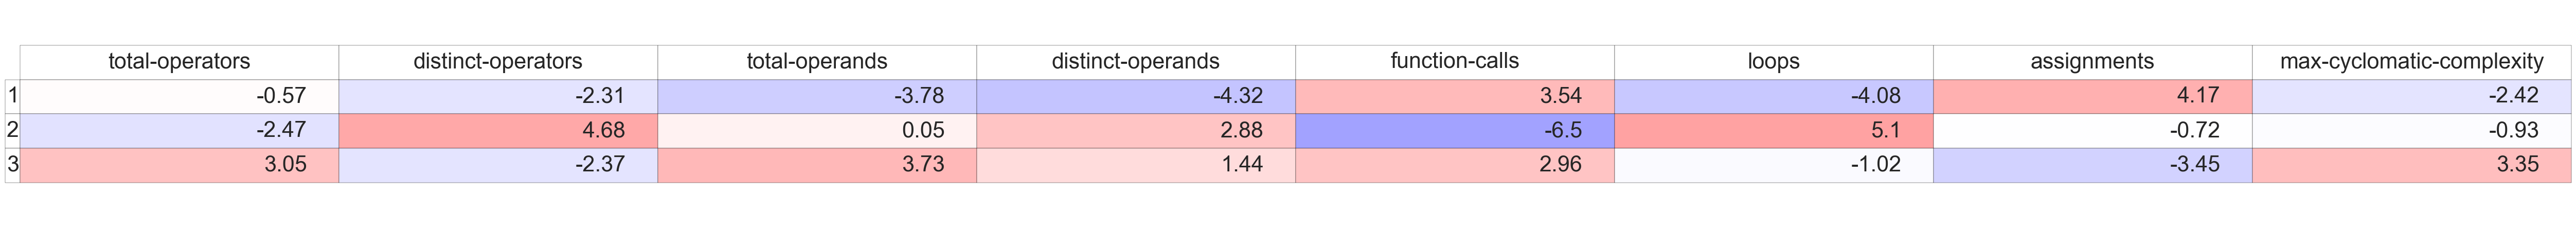

In [12]:
fig, ax = plt.subplots()

weights_table = ax.table(
    cellText=vals_1,
    rowLabels=weights_df_1.index,
    colLabels=first_cols,
    loc='center',
    cellColours=colors_1,
)

weights_table.set_fontsize(48)
weights_table.scale(8, 4)
ax.axis('off')

plt.show()

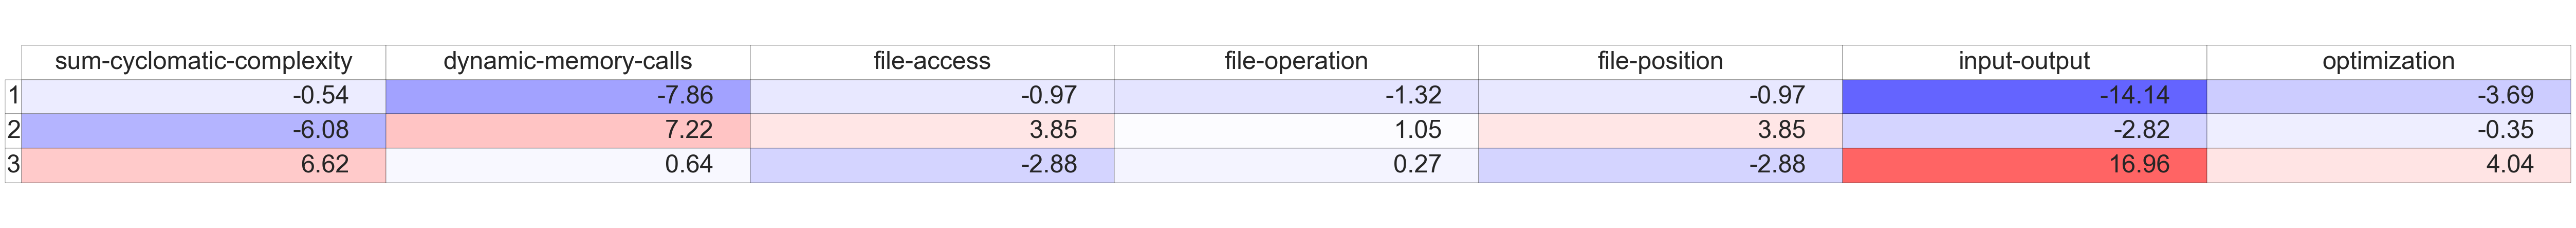

In [13]:
fig, ax = plt.subplots()

weights_table = ax.table(
    cellText=vals_2,
    rowLabels=weights_df_2.index,
    colLabels=second_cols,
    loc='center',
    cellColours=colors_2,
)

weights_table.set_fontsize(48)
weights_table.scale(8, 4)
ax.axis('off')

plt.show()